Authors       | Email                  |
:--------------|:----------------------|
Rezwanul      | rezwanul.cse@gmail.com |


## Problem: Predicting taxi fares in New York City
### Problem class: Supervised Regression

### Problem dataset link: [kaggle dataset link](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data) |

### Problem description:

 Diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage

### Problem Task:  Build a machine learning model to accurately predict whether or not the patients in the dataset have "Diabetes Mellitus" or not?

# Import Libraries

In [43]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve

from keras.models import Sequential
from keras.layers import Dense

# Loading data

In [2]:
# URL = "https://storage.googleapis.com/kagglesdsdata/datasets/228/482/diabetes.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1574499517&Signature=nsb4mSEK59QstjmPpcq7zWS%2FWiAgcDQVdywOIKVPZlp1wpbxSVbyRLUjuAhjT0hIVUIGDVNosfU57kw1%2B3xNyNswSFZ7SWTxUEkoJDBaivAshzFBGB87JtQNmeCeRcP4ys9Z%2FQ9ARbO7Cd0u6CzxwGAFzehtJKjhjTqWufshAA%2F41ml3jN%2Fbfmr1RdndFDCaCxHeLqTDvWzd0YntqyJ4sME277GMc5Z6qufxtaNZmrPNVD%2BX6N1ZJSw8vocIcrq2FpO8lZCmp96hwGPJe9mpKUnATCAlWcyfgNLwYAD3AzKHQiJVMMGHQjNIMAgeSz74qTlV7tHe9NFGCxaRzfkDGA%3D%3D&response-content-disposition=attachment%3B+filename%3Ddiabetes.csv"
# df = pd.read_csv(URL, names=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'])
df = pd.read_csv('data/diabetes.csv')

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Dataset Description
1. Pregnancies: Number of previous pregnancies
2. Glucose: Plasma glucose concentration
3. BloodPressure: Diastolic blood pressure
4. SkinThickness: Skin fold thickness measured from the triceps
5. Insulin : Blood serum insulin concentration
6. BMI: Body mass index
7. DiabetesPedigreeFunction: A summarized score that indicates the genetic predisposition of the patient for diabetes, as extrapolated from the patient's family record for diabetes
8. Age: Age in years
9. Outcome: The target variable we are trying to predict, 1 for patients that developed diabetes within five years of the initial measurement, and 0 otherwise

# Exploratory data analysis

### Visualizing the distribution

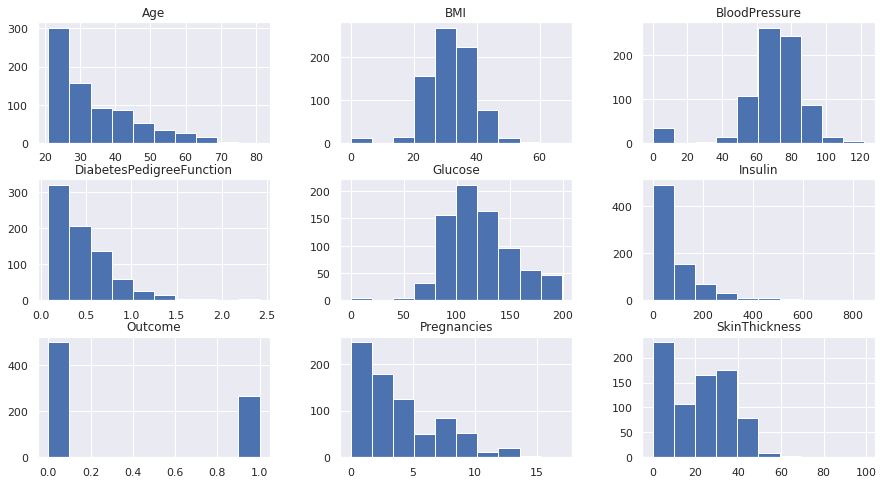

'\nInsight: From the histogram for Age, we can see that most of the data was collected from young\npeople, with the most common age group between 20-30 years old. We can also see that the \ndistribution for BMI, BloodPressure, and Glucose concentration is normally distributed (that is, \na bell curve shape), which is what we we expect when we collect such statistics from a population.\n'

In [3]:
df.hist(figsize=(15,8))
plt.show()

"""
Insight: From the histogram for Age, we can see that most of the data was collected from young
people, with the most common age group between 20-30 years old. We can also see that the 
distribution for BMI, BloodPressure, and Glucose concentration is normally distributed (that is, 
a bell curve shape), which is what we we expect when we collect such statistics from a population.
"""

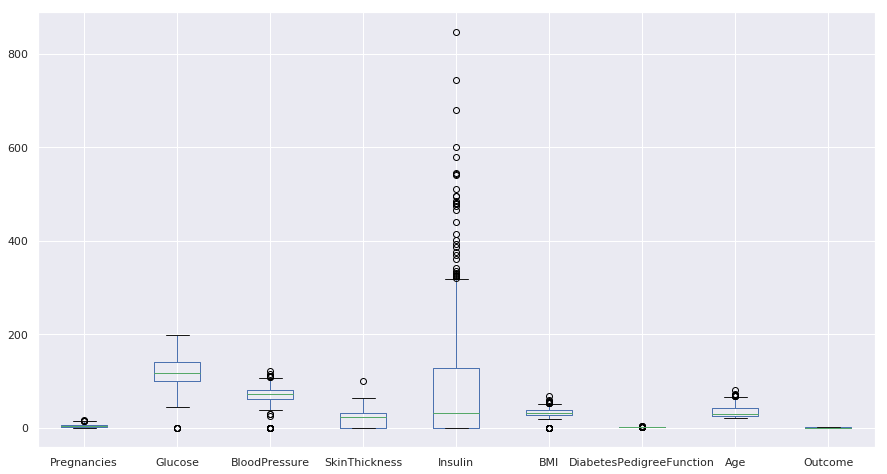

In [4]:
df.plot.box(figsize=(15,8))

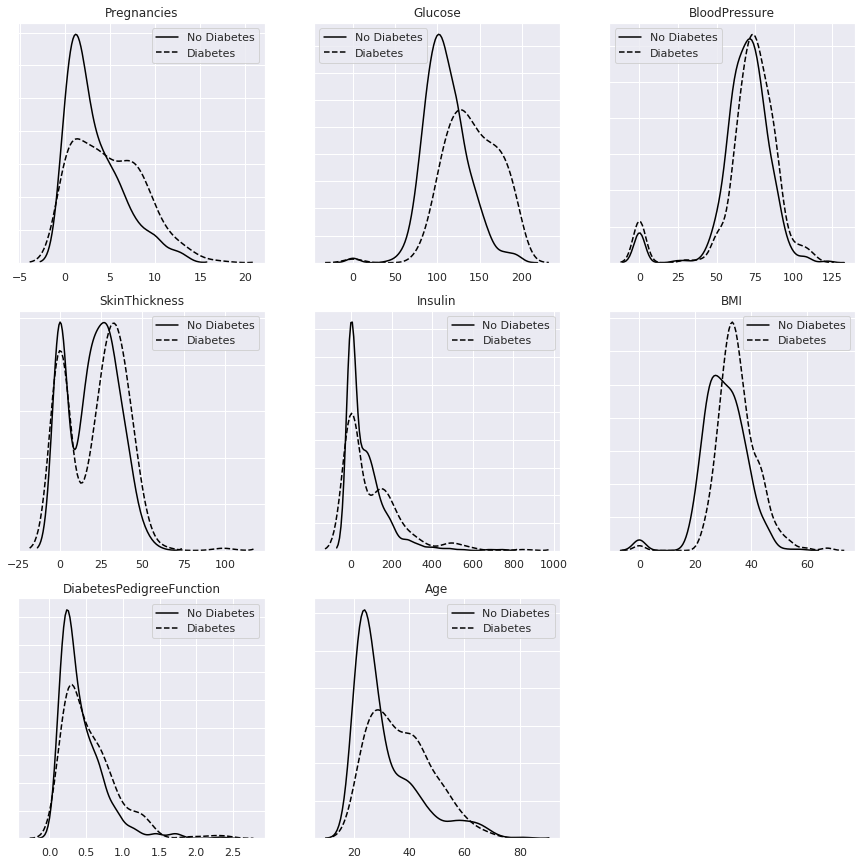

'\nInsight: Glucose variable, we can see that among the non-diabetics (solid line), the\ncurve has a normal distribution centered around the value 100. This tells us\nthat among non-diabetics, most people have a blood glucose value of 100\nmg/dL \n\nDiabetics (dashed line), the curve\nis wider and is centered around a value of 150. This tells us that diabetics\ntends to have a wider range of blood glucose value, and the average blood\nglucose value is around 150 mg/dL\n\nNote: A similar analysis can also be made for the variable BMI and Age\n'

In [5]:
# create a subplot of 3 x 3
plt.subplots(3, 3, figsize=(15, 15))

# Plot a density plot for each variable
for idx, col in enumerate(df.columns):
    ax = plt.subplot(3, 3, idx+1)
    ax.yaxis.set_ticklabels([])
    sns.distplot(df.loc[df.Outcome == 0][col], hist=False, axlabel=False, kde_kws={
                                                                                    'linestyle': '-',
                                                                                    'color': 'black',
                                                                                    'label': 'No Diabetes'
                                                                                    })
    sns.distplot(df.loc[df.Outcome == 1][col], hist=False, axlabel=False, kde_kws={
                                                                                    'linestyle': '--',
                                                                                    'color': 'black',
                                                                                    'label': 'Diabetes'
                                                                                    })
    ax.set_title(col)

# Hide the 9th subplot (bottom right) since there are only 8 plots
plt.subplot(3, 3, 9).set_visible(False)

plt.show()
"""
Insight: Glucose variable, we can see that among the non-diabetics (solid line), the
curve has a normal distribution centered around the value 100. This tells us
that among non-diabetics, most people have a blood glucose value of 100
mg/dL 

Diabetics (dashed line), the curve
is wider and is centered around a value of 150. This tells us that diabetics
tends to have a wider range of blood glucose value, and the average blood
glucose value is around 150 mg/dL

Note: A similar analysis can also be made for the variable BMI and Age
"""

In [6]:
"""
variables such as BloodPressure and SkinThickness, there is no significant difference in the distribution between
diabetics and non-diabetics. The two groups of people tend to have similar blood pressure and skin thickness values. 
Therefore, BloodPressure and SkinThickness are poorer predictors for diabetes.
"""

'\nvariables such as BloodPressure and SkinThickness, there is no significant difference in the distribution between\ndiabetics and non-diabetics. The two groups of people tend to have similar blood pressure and skin thickness values. \nTherefore, BloodPressure and SkinThickness are poorer predictors for diabetes.\n'

# Data Preprocessing

### Handling missing values

In [7]:
# Checking if there's any null values in the dataset

df.isnull().any()

# Insight: It seems like there are no missing values in the dataset, but are we sure about these?

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [8]:
# Statistical summary of the dataset
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


```
# Insight: 
There are 768 rows of data, and the Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, 
and BMI columns have a minimum value of 0.

# Note: 
The measurements for Glucose, BloodPressure, SkinThickness, Insulin, and BMI should never be 0

# Conclusions: 
This is an indication that there are missing values in the dataset.
The values were probably recorded as 0 due to certain issues during data collection. Perhaps the equipment 
was faulty, or the patient was unwilling to have their measurements taken.
```

In [9]:
def data_contain_any_zero_values(df: pd.DataFrame):
    print("Number of rows with 0 values for each variable")
    for col in df.columns:
        missing_rows = df.loc[df[col]==0].shape[0]
        print(col + ': ' + str(missing_rows))

In [10]:
data_contain_any_zero_values(df)

Number of rows with 0 values for each variable
Pregnancies: 111
Glucose: 5
BloodPressure: 35
SkinThickness: 227
Insulin: 374
BMI: 11
DiabetesPedigreeFunction: 0
Age: 0
Outcome: 500


In [11]:
# Insight:  In the Insulin column, there are 374 rows with 0 values. That is almost half of
# the data that we have! Clearly, we cannot discard these rows with 0 values as that will 
# use a significant drop in model performance

### Techniques to handle missing values
1. Remove (discard) any rows with missing values.
2. Replace the missing values with the mean/median/mode of the nonmissing values.
3. Predict the actual values using a separate machine learning model.

#### Note
The missing values comes from continuous variables such as Glucose,
BloodPressure, SkinThickness, Insulin, and BMI, we will replace the missing values
with the mean of the non-missing values.


In [12]:
df['Glucose'] = df['Glucose'].replace(0, np.nan)
df['BloodPressure'] = df['BloodPressure'].replace(0, np.nan)
df['SkinThickness'] = df['SkinThickness'].replace(0, np.nan)
df['Insulin'] = df['Insulin'].replace(0, np.nan)
df['BMI'] = df['BMI'].replace(0, np.nan)

In [13]:
data_contain_any_zero_values(df)

# Insight: we did not modify the Pregnancies column as 0 values in that column (that is, 0 previous pregnancies) are perfectly valid.

Number of rows with 0 values for each variable
Pregnancies: 111
Glucose: 0
BloodPressure: 0
SkinThickness: 0
Insulin: 0
BMI: 0
DiabetesPedigreeFunction: 0
Age: 0
Outcome: 500


In [14]:
# Replaceing NaN values with the mean of the non-missing values
df["Glucose"] = df["Glucose"].fillna(df["Glucose"].mean())
df["BloodPressure"] = df["BloodPressure"].fillna(df["BloodPressure"].mean())
df["SkinThickness"] = df["SkinThickness"].fillna(df["SkinThickness"].mean())
df["Insulin"] = df["Insulin"].fillna(df["Insulin"].mean())
df["BMI"] = df["BMI"].fillna(df["BMI"].mean())

## Data Standardization

In [15]:
# Data standardization is another important technique in data preprocessing.
# The goal of data standardization is to transform the numeric variables so that
# each variable has zero mean and unit variance

# Note
In neural networks, it is important to standardize the data in order to ensure that the backpropagation algorithm
works as intended. Another positive effect of data standardization is that it shrinks the magnitude of the variables, 
transforming them to a scale that is more proportional.

variables such as Insulin and DiabetesPedigreeeFunction have vastly different scales; the maximum value for Insulin 
is 846 while the maximum value for DiabetesPedigreeeFunction is only 2.42. With such different scales, the variable 
with the greater scale tends to dominate when training the neural network, causing the neural network to inadvertently 
place more emphasis on the variable with a greater scale.

In [17]:
df_scaled = preprocessing.scale(df)

# coverting df_scaled into dataframe object
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

# Using the origin Outcome column in the scaled data frame
df_scaled['Outcome'] = df['Outcome']

df = df_scaled

In [18]:
df.describe().loc[['mean', 'std', 'max'], ].round(2).abs()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
mean,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.35
std,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,0.48
max,3.91,2.54,4.1,7.95,8.13,5.04,5.88,4.06,1.00


# Spliting the data into training, testing, validation sets

In [20]:
# ### Training set: 
# The neural network will be trained on this subset of the data.
# ### Validation set: 
# This set of data allows us to perform hyperparameter tuning (that is, 
# tuning the number of hidden layers) using an unbiased source of data.
# ### Testing set: 
# The final evaluation of the neural network will be based on this subset 
# of the data.

#### 80% training and 20% testing, and then to split the training data into 80% training and 20% validation again

In [22]:
X = df.loc[:, df.columns != 'Outcome']
y = df.loc[:, 'Outcome']

In [23]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
# Train-Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# Model Selection

### Multi layer Perceptron (MLPs)

An MLP is a class of feedforward neural network. This multilayer neural network architecture 
and non-linear activation allows MLPs to produce non-linear decision boundaries, which is crucial 
in multi-dimensional realworld datasets such as the Pima Indians Diabetes dataset.

## Model architecture

| Input Layer -> | 1st Hidden Layer ->| 2nd Hidden Layer -> | Output Layer |
:--------------|:----------------------|:--------------|:----------------------|

### Activation functions
1. ReLU
2. Sigmoid

##### ReLU (Rectified Linear Unit)
ReLU is always used as the activation function for our intermediate hidden layers (that is, non-output layer)

##### Sigmoid
It squashes the output between 0 and 1 (binary output).

# Model Building

In [28]:
model = Sequential()

In [31]:
# Add the first hidden layer
model.add(Dense(32, activation='relu', input_dim=8))

# Add the second hidden layer
model.add(Dense(16, activation='relu'))

# Add the output layer
model.add(Dense(1, activation='sigmoid'))

# Model compilation

#### Optimizer: 
Let's use the adam optimizer, which is a popular optimizer in Keras. 
For most datasets, the adam optimizer will work well without much
tuning.
#### Loss function: 
We'll use binary_crossentropy as our loss function since the
problem at hand is a binary classification problem.
#### Metrics: 
We'll use accuracy (that is, the percentage of correctly classified
samples) as our evaluation metric.

In [32]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
             )



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Model Training

In [33]:
# Train the model for 200 epochs
model.fit(X_train, y_train, epochs=200)


Epoch 1/200
491/491 [==============================] - 1s 2ms/step - loss: 0.6548 - acc: 0.6945
Epoch 2/200
491/491 [==============================] - 0s 170us/step - loss: 0.5909 - acc: 0.7454
Epoch 3/200
491/491 [==============================] - 0s 179us/step - loss: 0.5233 - acc: 0.7515
Epoch 4/200
491/491 [==============================] - 0s 164us/step - loss: 0.4748 - acc: 0.7637
Epoch 5/200
491/491 [==============================] - 0s 126us/step - loss: 0.4506 - acc: 0.7678
Epoch 6/200
491/491 [==============================] - 0s 133us/step - loss: 0.4368 - acc: 0.7760
Epoch 7/200
491/491 [==============================] - 0s 138us/step - loss: 0.4302 - acc: 0.7923
Epoch 8/200
491/491 [==============================] - 0s 189us/step - loss: 0.4239 - acc: 0.7984
Epoch 9/200
491/491 [==============================] - 0s 293us/step - loss: 0.4179 - acc: 0.7984
Epoch 10/200
491/491 [==============================] - 0s 304us/step - loss: 0.4140 - acc: 0.7984
Epoch 11/200
491/491

# Result Analysis

In [34]:
# Having successfully trained our MLP, let's evaluate our model based on the
# testing accuracy, confusion matrix, and receiver operating characteristic
# (ROC) curve.

### Testing accuracy

In [39]:
scores = model.evaluate(X_train, y_train)
print(f"Training Accuracy: {scores[1] * 100}\n")

scores = model.evaluate(X_test, y_test)
print(f"Testing Accuracy: {scores[1] * 100}\n")

491/491 [==============================] - 0s 307us/step
Training Accuracy: 100.0

154/154 [==============================] - 0s 44us/step
Testing Accuracy: 66.88311703793414



## Confusion matrix

In [40]:
# The confusion matrix is a useful visualization tool that provides analysis on
# the true negative, false positive, false negative, and true positives made by our
# model

# True negative: Actual class is negative (no diabetes), and the model predicted negative (no diabetes)
# False positive: Actual class is negative (no diabetes), but the model predicted positive (diabetes)
# False negative: Actual class is positive (diabetes), but the model predicted negative (no diabetes)
# True positive: Actual class is positive (diabetes), and the model predicted positive (diabetes)

Text(30.5, 0.5, 'Actual')

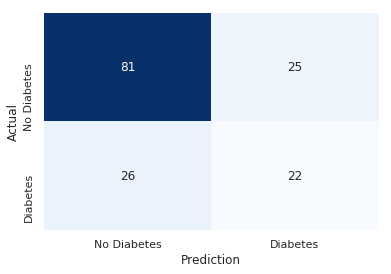

In [42]:
y_test_pred = model.predict_classes(X_test)
c_matrix = confusion_matrix(y_test, y_test_pred)

ax = sns.heatmap(c_matrix, annot=True,
                 xticklabels=['No Diabetes', 'Diabetes'],
                 yticklabels=['No Diabetes', 'Diabetes'],
                 cbar=False, cmap='Blues'
                )
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")

## Roc Curve

In [44]:
# The ROC curve is a plot with the True Positive Rate (TPR) on the y axis and the False Positive Rate (FPR) on the x axis
# Analyze the ROC curve, we look at the area under the curve (AUC) to evaluate the performance of the model that produced the curve. 
# A large AUC indicates that the model is able to differentiate the respective classes with high accuracy, while a low AUC indicates 
# that the model makes poor, often wrong predictions. A ROC curve that lies on the diagonal indicates that the model does no better 
# than random

In [45]:
y_test_pred_probs = model.predict(X_test)

In [46]:
FPR, TPR, _= roc_curve(y_test, y_test_pred_probs)

Text(0, 0.5, 'True Positive Rate')

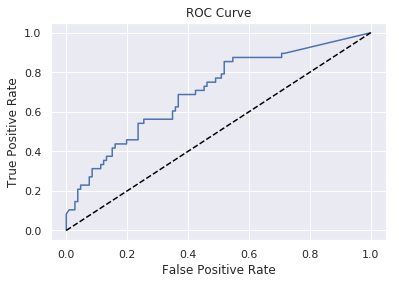

In [47]:
# Ploting False positive rate and True positive rate
plt.plot(FPR, TPR)
plt.plot([0, 1], [0, 1], '--', color='black')  # diagonal line
plt.title("ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
# Feature engineering is the process of using one's domain knowledge of the problem to create new features for the machine learning algorithm

# Feature selection is used when we believe that the original dataset contains too much noise, and removing the noisy features (features that are 
# not strong predictors) may improve model performance